In [784]:
import numpy as np
import pandas as pd
import requests
import wptools
import re
import os
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set()

In [785]:
os.getcwd()

'C:\\Users\\musta\\Documents\\Git\\WeRateTwitter'

In [786]:
tw = pd.read_csv('twitter-archive-enhanced.csv')

In [787]:
tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [788]:
tw[tw.rating_denominator!=10].sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
1779,677716515794329600,NaN,NaN,2015-12-18 05:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677716515794329600/photo/1,144,120,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
1635,684222868335505415,NaN,NaN,2016-01-05 04:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684222868335505415/photo/1,121,110,None,None,None,None,None


In [789]:
imgs = pd.read_csv('image-predictions.tsv', sep= '\t')

In [790]:
imgs.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


# Assess

### Quality Issues
#### Twitter Archive Table
- Timestamp needs to be formatted correctly                  
- Data also includes (RT) Retweet data for 181 items that need to be removed and in their own table
- Missing 59 expanded_urls (2297 vs 2356 total)
- Rating Denominator has values other than 10 (2333 counts of 10) extract from text, look for date errors
- Missing doggo, fluffer, pupper data. Need to be extracted from text
- Drop retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp
- Dog names are incorrect and have random words at times
- Putting hashtags in their own column, used a lot for marketing and should be helpful

### Tidiness Issues
#### Twitter Archive Table
- Retweets of 181 items that need to be in their own table
- Contains 78 replies (in_reply_to_user_id) need to be on their own table
- Doggo, Fluffer, and Pupper are not fields

# Clean

## Define:
- Timestamp needs to be in date time format so it can be queried easily (Twitter Archive Table)

##### Code:

In [791]:
tw_clean = tw.copy()
tw_clean.timestamp.sample(1)

1259    2016-03-17 01:11:26 +0000
Name: timestamp, dtype: object

In [792]:
#Changing timestamp format to date and time format with to_datetime function
tw_clean['timestamp'] = pd.to_datetime(tw_clean.timestamp)

##### Test:

In [793]:
tw_clean.dtypes

tweet_id                      int64         
in_reply_to_status_id         float64       
in_reply_to_user_id           float64       
timestamp                     datetime64[ns]
source                        object        
text                          object        
retweeted_status_id           float64       
retweeted_status_user_id      float64       
retweeted_status_timestamp    object        
expanded_urls                 object        
rating_numerator              int64         
rating_denominator            int64         
name                          object        
doggo                         object        
floofer                       object        
pupper                        object        
puppo                         object        
dtype: object

##### Define:
- Data also includes (RT) Retweet data for 181 items need to be in their own table (Tidiness)
- Contains 78 replies (in_reply_to_user_id) need to be in their own table (Tidiness)

##### Code:

In [794]:
tw_retweets = tw_clean[tw_clean['text'].str.contains('RT @')]

In [795]:
tw_clean.drop(tw_clean[tw_clean['text'].str.contains('RT @')].index, inplace=True)

##### Test:

In [796]:
tw_clean[tw_clean['text'].str.contains('RT @')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


## Define:
- Missing 59 expanded_urls (2297 vs 2356 total) (Twitter Archive Table)

##### Code:

In [797]:
#Looks like these are replies, so this is a good way to filter them out
tw_clean[tw_clean.expanded_urls.isnull()].count()

tweet_id                      58
in_reply_to_status_id         55
in_reply_to_user_id           55
timestamp                     58
source                        58
text                          58
retweeted_status_id           0 
retweeted_status_user_id      0 
retweeted_status_timestamp    0 
expanded_urls                 0 
rating_numerator              58
rating_denominator            58
name                          58
doggo                         58
floofer                       58
pupper                        58
puppo                         58
dtype: int64

In [798]:
#There are 78 replies, 23 of them have expanded urls
tw_clean[(tw_clean.in_reply_to_status_id.notnull())].count()

tweet_id                      78
in_reply_to_status_id         78
in_reply_to_user_id           78
timestamp                     78
source                        78
text                          78
retweeted_status_id           0 
retweeted_status_user_id      0 
retweeted_status_timestamp    0 
expanded_urls                 23
rating_numerator              78
rating_denominator            78
name                          78
doggo                         78
floofer                       78
pupper                        78
puppo                         78
dtype: int64

In [799]:
#So if the reply status is not null and expanded url is null then its a reply comment to someone elses post
#We can put these items on a different table because it does not involve one of their pictures or original posts.
tw_clean[(tw_clean.in_reply_to_status_id.notnull()) & (tw_clean.expanded_urls.isnull())].sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
1479,693582294167244802,6.935722e+17,1.198989e+09,2016-01-30 23:51:19,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Personally I'd give him an 11/10. Not sure why you think you're qualified to rate such a stellar pup.\n@CommonWhiteGirI,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
498,813130366689148928,8.131273e+17,4.196984e+09,2016-12-25 21:12:41,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been informed by multiple sources that this is actually a dog elf who's tired from helping Santa all night. Pupgraded to 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
1663,682808988178739200,6.827884e+17,4.196984e+09,2016-01-01 06:22:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible",NaN,NaN,NaN,NaN,20,16,None,None,None,None,None


In [800]:
tw_clean[(tw_clean.in_reply_to_status_id.notnull()) & (tw_clean.expanded_urls.isnull())].count()

tweet_id                      55
in_reply_to_status_id         55
in_reply_to_user_id           55
timestamp                     55
source                        55
text                          55
retweeted_status_id           0 
retweeted_status_user_id      0 
retweeted_status_timestamp    0 
expanded_urls                 0 
rating_numerator              55
rating_denominator            55
name                          55
doggo                         55
floofer                       55
pupper                        55
puppo                         55
dtype: int64

In [801]:
tw_replies = tw_clean[(tw_clean.in_reply_to_status_id.notnull()) & (tw_clean.expanded_urls.isnull())]

In [802]:
tw_clean.drop(tw_clean[(tw_clean.in_reply_to_status_id.notnull()) & (tw_clean.expanded_urls.isnull())].index, inplace=True)

In [803]:
tw_clean[(tw_clean.in_reply_to_status_id.notnull()) & (tw_clean.expanded_urls.isnull())].count()

tweet_id                      0
in_reply_to_status_id         0
in_reply_to_user_id           0
timestamp                     0
source                        0
text                          0
retweeted_status_id           0
retweeted_status_user_id      0
retweeted_status_timestamp    0
expanded_urls                 0
rating_numerator              0
rating_denominator            0
name                          0
doggo                         0
floofer                       0
pupper                        0
puppo                         0
dtype: int64

In [804]:
#If the reply status is not null & there is an expanded url, then its a reply to one of their own tweets
#These have the same charcteristics of a new post except its relevant to a previous post so will keep it in the table
tw_clean[(tw_clean.in_reply_to_status_id.notnull()) & (tw_clean.expanded_urls.notnull())].sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14,10,None,None,None,None,None
1330,705786532653883392,7.032559e+17,4.196984e+09,2016-03-04 16:06:36,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Seriously, add us 🐶 11/10 for sad wet pupper https://t.co/xwPE9faVZR",NaN,NaN,NaN,https://twitter.com/dog_rates/status/705786532653883392/photo/1,11,10,None,None,None,pupper,None
1127,729838605770891264,7.291135e+17,4.196984e+09,2016-05-10 01:00:58,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Challenge completed"" \n(pupgraded to 12/10) https://t.co/85dTK7XCXB",NaN,NaN,NaN,https://twitter.com/dog_rates/status/729838605770891264/video/1,12,10,None,None,None,None,None
1452,695767669421768709,6.753494e+17,4.196984e+09,2016-02-06 00:35:13,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",If you are aware of who is making these please let me know. 13/10 vroom vroom https://t.co/U0D1sbIDrG,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695767669421768709/photo/1,13,10,None,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tessa. She is also very pleased after finally meeting her biological father. 10/10 https://t.co/qDS1aCqppv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438988365824/photo/1,10,10,Tessa,None,None,None,None


In [805]:
#We still have 3 items with missing expanded URLS, and this is because they don't have picutres
tw_clean[tw_clean.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
375,828361771580813312,NaN,NaN,2017-02-05 21:56:51,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Beebop and Doobert should start a band 12/10 would listen,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
707,785515384317313025,NaN,NaN,2016-10-10 16:20:36,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Today, 10/10, should be National Dog Rates Day",NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
1445,696518437233913856,NaN,NaN,2016-02-08 02:18:30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Oh my god 10/10 for every little hot dog pupper,NaN,NaN,NaN,NaN,10,10,None,None,None,pupper,None


In [806]:
tw_clean.drop(tw_clean[tw_clean.expanded_urls.isnull()].index, inplace=True)

In [807]:
tw_clean = tw_clean.reset_index(drop=True)

##### Test:

In [808]:
tw_clean[tw_clean.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [809]:
#We see 23 in reply to status, but they are replies with new pictures and relevent.
tw_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 17 columns):
tweet_id                      2117 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null datetime64[ns]
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
doggo                         2117 non-null object
floofer                       2117 non-null object
pupper                        2117 non-null object
puppo                         2117 non-null object
dtypes: datetime64[ns](1), flo

## Define:
Rating Denominator has values other than 10 (2333 counts of 10) extract from text, look for pup(s), pupper(s) and date errors

In [810]:
#Most of these are for multiple puppy ratings, but a few like the 24/7, 4/20, and 7/11 items are errors that need to be updated
#setting option to -1 to show all of the text
pd.set_option('display.max_colwidth', -1)
tw_clean[tw_clean.rating_denominator != 10][['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
341,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
405,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
702,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
857,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
908,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
953,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
990,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1016,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1041,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1061,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


In [811]:
#We can the second item is NaN because they do not rate it
#The last row is also NaN because they rate it 9/10 which is out of the ordinary since they always rate dogs 10/10 or higher
tw_clean[tw_clean.rating_denominator != 10].text.str.extract('(\d{2,3}/\d{2,3})', expand=False).str.split('/')

341     [84, 70]  
405     NaN       
702     [165, 150]
857     [14, 10]  
908     [204, 170]
953     [13, 10]  
990     [50, 50]  
1016    [99, 90]  
1041    [80, 80]  
1061    [45, 50]  
1136    [60, 50]  
1218    [44, 40]  
1410    [143, 130]
1411    [121, 110]
1438    [10, 10]  
1552    [144, 120]
1615    [88, 80]  
2096    NaN       
Name: text, dtype: object

In [812]:
tw_clean.drop(tw_clean.index[[405, 2096]],inplace=True)

In [813]:
tw_clean[tw_clean.rating_denominator != 10].text.str.extract('(\d{2,3}/\d{2,3})', expand=False).str.split('/')

341     [84, 70]  
702     [165, 150]
857     [14, 10]  
908     [204, 170]
953     [13, 10]  
990     [50, 50]  
1016    [99, 90]  
1041    [80, 80]  
1061    [45, 50]  
1136    [60, 50]  
1218    [44, 40]  
1410    [143, 130]
1411    [121, 110]
1438    [10, 10]  
1552    [144, 120]
1615    [88, 80]  
Name: text, dtype: object

In [814]:
#Setting the raing on the remaining items without denominators of 10 to be the correct number
tw_clean.set_value(tw_clean[tw_clean.rating_denominator != 10].index, 'rating_numerator', tw_clean[tw_clean.rating_denominator != 10].text.str.extract('(\d{2,3}/\d{2,3})', expand=False).str.split('/').str[0])
tw_clean.set_value(tw_clean[tw_clean.rating_denominator != 10].index, 'rating_denominator', tw_clean[tw_clean.rating_denominator != 10].text.str.extract('(\d{2,3}/\d{2,3})', expand=False).str.split('/').str[1])

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://

##### Test

In [815]:
#We can see that 9/11, 4/20, and 7/11 are no longer used as the numerator or denominator
tw_clean[tw_clean.rating_denominator != 10][['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
341,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
702,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
857,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14,10
908,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
953,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,13,10
990,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1016,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1041,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1061,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50
1136,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50


In [816]:
tw_clean[tw_clean.rating_denominator != 10].loc[:,('rating_numerator','rating_denominator')]

,rating_numerator,rating_denominator
341,84,70
702,165,150
857,14,10
908,204,170
953,13,10
990,50,50
1016,99,90
1041,80,80
1061,45,50
1136,60,50


## Define
Missing doggo, pupper, puppo info extract from text

In [817]:
tw_unknown = tw_clean[(tw_clean.doggo == 'None') & (tw_clean.pupper == 'None') & (tw_clean.puppo == 'None')]

In [818]:
tw_unknown.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786 entries, 0 to 2116
Data columns (total 17 columns):
tweet_id                      1786 non-null int64
in_reply_to_status_id         20 non-null float64
in_reply_to_user_id           20 non-null float64
timestamp                     1786 non-null datetime64[ns]
source                        1786 non-null object
text                          1786 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1786 non-null object
rating_numerator              1786 non-null object
rating_denominator            1786 non-null object
name                          1786 non-null object
doggo                         1786 non-null object
floofer                       1786 non-null object
pupper                        1786 non-null object
puppo                         1786 non-null object
dtypes: datetime64[ns](1), f

#### Code

In [819]:
tw_known = tw_unknown[(tw_unknown.text.str.contains('doggo')) | (tw_unknown.text.str.contains('pupper')) | (tw_unknown.text.str.contains('puppo'))]

In [820]:
tw_known.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 50 to 1907
Data columns (total 17 columns):
tweet_id                      37 non-null int64
in_reply_to_status_id         1 non-null float64
in_reply_to_user_id           1 non-null float64
timestamp                     37 non-null datetime64[ns]
source                        37 non-null object
text                          37 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 37 non-null object
rating_numerator              37 non-null object
rating_denominator            37 non-null object
name                          37 non-null object
doggo                         37 non-null object
floofer                       37 non-null object
pupper                        37 non-null object
puppo                         37 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object

In [821]:
doggo = tw_known.loc[tw_known.text.str.contains('doggo')].index

In [822]:
pupper = tw_known.loc[tw_known.text.str.contains('pupper')].index

In [823]:
puppo = tw_known.loc[tw_known.text.str.contains('puppo')].index

In [824]:
tw_clean.doggo.loc[doggo] = 'doggo'

C:\Users\musta\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [825]:
tw_clean.pupper.loc[pupper] = 'pupper'

C:\Users\musta\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [826]:
tw_clean.puppo.loc[puppo] = 'puppo'

C:\Users\musta\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Test

In [827]:
#We can see below that now the unknown items went from 1786 to 1749
#This is a difference of 37, which is our known dataframe of unkown items that actually had the type of dog name in the text
tw_unknown = tw_clean[(tw_clean.doggo == 'None') & (tw_clean.pupper == 'None') & (tw_clean.puppo == 'None')]
tw_unknown.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1749 entries, 0 to 2116
Data columns (total 17 columns):
tweet_id                      1749 non-null int64
in_reply_to_status_id         19 non-null float64
in_reply_to_user_id           19 non-null float64
timestamp                     1749 non-null datetime64[ns]
source                        1749 non-null object
text                          1749 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1749 non-null object
rating_numerator              1749 non-null object
rating_denominator            1749 non-null object
name                          1749 non-null object
doggo                         1749 non-null object
floofer                       1749 non-null object
pupper                        1749 non-null object
puppo                         1749 non-null object
dtypes: datetime64[ns](1), f

## Define:
- Removing the unecessary columns, retweeted_status_id, retweeted_user_id, and retweeted_status_timestamp

In [828]:
tw_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2115 entries, 0 to 2116
Data columns (total 17 columns):
tweet_id                      2115 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2115 non-null datetime64[ns]
source                        2115 non-null object
text                          2115 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2115 non-null object
rating_numerator              2115 non-null object
rating_denominator            2115 non-null object
name                          2115 non-null object
doggo                         2115 non-null object
floofer                       2115 non-null object
pupper                        2115 non-null object
puppo                         2115 non-null object
dtypes: datetime64[ns](1), f

#### Code

In [829]:
tw_clean = tw_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1)
tw_clean.reset_index(drop=True)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so e

#### Test

In [830]:
tw_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2115 entries, 0 to 2116
Data columns (total 14 columns):
tweet_id                 2115 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                2115 non-null datetime64[ns]
source                   2115 non-null object
text                     2115 non-null object
expanded_urls            2115 non-null object
rating_numerator         2115 non-null object
rating_denominator       2115 non-null object
name                     2115 non-null object
doggo                    2115 non-null object
floofer                  2115 non-null object
pupper                   2115 non-null object
puppo                    2115 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(10)
memory usage: 327.9+ KB


## Define
Dog names are incorrect and have random words at times

In [831]:
#Using regular expressions to find names with lower case letters
bad_names = tw_clean[tw_clean['name'].str.contains('(^[a-z]\w{0,})')]

C:\Users\musta\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [832]:
#We can see this gathers many of the incorrect names
bad_names['name'].value_counts()

a               55
the             8 
an              5 
very            4 
one             4 
quite           3 
just            3 
actually        2 
getting         2 
not             2 
life            1 
space           1 
light           1 
by              1 
infuriating     1 
this            1 
unacceptable    1 
mad             1 
incredibly      1 
all             1 
my              1 
officially      1 
such            1 
old             1 
his             1 
Name: name, dtype: int64

#### Code

In [833]:
bad_names_index = bad_names.index

In [834]:
for row in bad_names_index:
    tw_clean.at[row, 'name'] = ''

In [835]:
#Replacing all the names with lower case letters with '' instead
tw_clean[tw_clean['name'].str.contains('(^[a-z]\w{0,})')]

C:\Users\musta\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Test

In [836]:
#Can see there are no more names that begin with lower case letters
tw_clean[tw_clean['name'].str.contains('(^[a-z]\w{0,})', na=False)]

C:\Users\musta\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


## Define
- Hashtags should be parsed in their own category also because its used for sorting and marketing by others

#### Code

In [837]:
tw_clean['hashtags'] = tw_clean['text'].str.extract('\#(\w+)', expand=False)

#### Test

In [838]:
tw_clean[tw_clean.hashtags.notnull()].count()

tweet_id                 24
in_reply_to_status_id    0 
in_reply_to_user_id      0 
timestamp                24
source                   24
text                     24
expanded_urls            24
rating_numerator         24
rating_denominator       24
name                     24
doggo                    24
floofer                  24
pupper                   24
puppo                    24
hashtags                 24
dtype: int64

In [839]:
tw_clean.hashtags.value_counts()

BarkWeek                 9
PrideMonth               3
BellLetsTalk             1
K9VeteransDay            1
ScienceMarch             1
WKCDogShow               1
dogsatpollingstations    1
WomensMarch              1
NoDaysOff                1
Canada150                1
notallpuppers            1
ImWithThor               1
FinalFur                 1
PrideMonthPuppo          1
Name: hashtags, dtype: int64

It looks like the hashtags are mostly used during barkweek, and during holidays and events

WeRateDogs is popular but maybe if they used hashtags they'd increase their visibility. I looked on instagram, where hashtags are very popular, and there's a lack of hashtags there which I found very odd since the internet uses them for search.

## Define:
Doggo, Fluffer, and Pupper need to be on one column for tidiness

#### Code

In [862]:
tw_clean['dog_stage'] = tw_clean['doggo'].astype(str) + ', ' + tw_clean['pupper'].astype(str) + ', ' + tw_clean['puppo'].astype(str)

In [863]:
tw_clean['dog_stage'] = tw_clean['dog_stage'].str.replace('None, ', '')
tw_clean['dog_stage'] = tw_clean['dog_stage'].str.replace(', None', '')

In [865]:
tw_clean.dog_stage.value_counts()

None             1749
pupper           246 
doggo            81  
puppo            28  
doggo, pupper    10  
doggo, puppo     1   
Name: dog_stage, dtype: int64

In [867]:
tw_clean.drop(['doggo', 'pupper', 'puppo'], axis=1, inplace=True)

In [868]:
tw_clean.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,floofer,hashtags,dog_stage
1725,673580926094458881,NaN,NaN,2015-12-06 19:13:01,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you ask your professor about extra credit on the last day of class. 8/10 https://t.co/H6rqZyE4NP,https://twitter.com/dog_rates/status/673580926094458881/photo/1,8,10,None,None,NaN,None


In [869]:
from matplotlib.dates import date2num

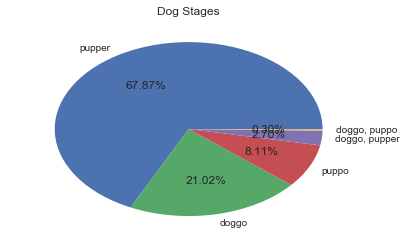

In [923]:
tw_clean.dog_stage[tw_clean.dog_stage !='None'].value_counts().plot(kind='pie', title='Dog Stages', autopct='%.2f%%')
plt.axis('off')
plt.savefig('dogstages.png', bbox_inches='tight')
plt.show()

Puppers are by far the most instagrammed dogs because puppies are more popular

Or maybe its just the most commonly used word to describe them dogs

In [871]:
tw_clean = pd.merge(tw_clean, imgs, how='inner', on='tweet_id')

In [872]:
tw_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 0 to 1991
Data columns (total 24 columns):
tweet_id                 1992 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1992 non-null datetime64[ns]
source                   1992 non-null object
text                     1992 non-null object
expanded_urls            1992 non-null object
rating_numerator         1992 non-null object
rating_denominator       1992 non-null object
name                     1992 non-null object
floofer                  1992 non-null object
hashtags                 22 non-null object
dog_stage                1992 non-null object
jpg_url                  1992 non-null object
img_num                  1992 non-null int64
p1                       1992 non-null object
p1_conf                  1992 non-null float64
p1_dog                   1992 non-null bool
p2                       1992 non-null object
p2_conf           

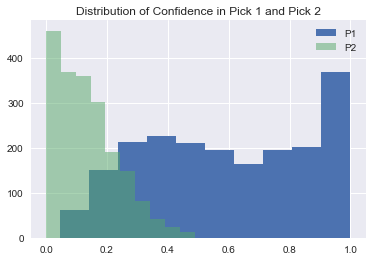

In [922]:
plt.hist(tw_clean.p1_conf, label='P1')
plt.hist(tw_clean.p2_conf, alpha=0.5, label='P2')
plt.title('Distribution of Confidence in Pick 1 and Pick 2')
plt.legend()
plt.savefig('images.png', bbox_inches='tight')
plt.show()

## Using Tweepy and Twitter API to get retweet and like data

#### Code

#### Turning the below 4 into markdowns as I already gathered the data with tweepy and its saved in a file

#Tweepy api info
import tweepy

consumer_key = XXXX
consumer_secret = XXXX

access_token = XXXX
access_token_secret = XXXX

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

#public_tweets = api.search('XYZ')

#for tweet in public tweets:

tweetids = list(tw_clean.tweet_id)

tweet_api_pulls = {}
for tweet in tweetids:
    try:
        tweet_data = api.get_status(tweet, wait_on_rate_limit = True)
        tweet_api_pulls[str(tweet)] = tweet_data._json
    except:
        print('error on {}' .format(tweet))        

import json
with open('data.txt', 'w') as outfile:
    json.dump(tweet_api_pulls, outfile)

In [874]:
#Testing to see if it works
with open('data.txt') as json_file:
    data = json.load(json_file)
    for tweetid in data:
        print(tweetid)
        print(data[tweetid]['retweet_count'])
        print(data[tweetid]['favorite_count'])
        break

892420643555336193
8792
39360


In [875]:
tweetdf = []

with open('data.txt') as json_file:
    data = json.load(json_file)
    for tweetid in data:
        favorites = data[tweetid]['favorite_count']
        retweets = data[tweetid]['retweet_count']
        tweetdf.append({'tweet_id' : tweetid,
                       'retweets' : retweets,
                       'favorites': favorites})

In [876]:
#adding columns because without specifying columns the order is different and tweet_id is the last column
tweet_df = pd.DataFrame(tweetdf, columns = ['tweet_id', 'retweets', 'favorites'])

#### Test

In [877]:
tweet_df.head()

,tweet_id,retweets,favorites
0,892420643555336193,8792,39360
1,892177421306343426,6447,33688
2,891815181378084864,4272,25390
3,891689557279858688,8884,42737
4,891327558926688256,9662,40902


In [878]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115 entries, 0 to 2114
Data columns (total 3 columns):
tweet_id     2115 non-null object
retweets     2115 non-null int64
favorites    2115 non-null int64
dtypes: int64(2), object(1)
memory usage: 49.6+ KB


#### Now Merging the tweet info with the clean dataframe

In [879]:
tw_clean.tweet_id = tw_clean.tweet_id.astype(str)

In [880]:
tw_clean = pd.merge(tw_clean, tweet_df, how='inner', on='tweet_id')

In [881]:
tw_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 0 to 1991
Data columns (total 26 columns):
tweet_id                 1992 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1992 non-null datetime64[ns]
source                   1992 non-null object
text                     1992 non-null object
expanded_urls            1992 non-null object
rating_numerator         1992 non-null object
rating_denominator       1992 non-null object
name                     1992 non-null object
floofer                  1992 non-null object
hashtags                 22 non-null object
dog_stage                1992 non-null object
jpg_url                  1992 non-null object
img_num                  1992 non-null int64
p1                       1992 non-null object
p1_conf                  1992 non-null float64
p1_dog                   1992 non-null bool
p2                       1992 non-null object
p2_conf          

In [882]:
tw1 = tw_clean.copy()

In [883]:
tw1 = tw1.drop_duplicates(subset=['tweet_id', 'dog_stage'], keep=False)

In [884]:
tw1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 0 to 1991
Data columns (total 26 columns):
tweet_id                 1992 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1992 non-null datetime64[ns]
source                   1992 non-null object
text                     1992 non-null object
expanded_urls            1992 non-null object
rating_numerator         1992 non-null object
rating_denominator       1992 non-null object
name                     1992 non-null object
floofer                  1992 non-null object
hashtags                 22 non-null object
dog_stage                1992 non-null object
jpg_url                  1992 non-null object
img_num                  1992 non-null int64
p1                       1992 non-null object
p1_conf                  1992 non-null float64
p1_dog                   1992 non-null bool
p2                       1992 non-null object
p2_conf          

In [912]:
np.corrcoef(tw_clean.retweets, tw_clean.favorites)

array([[ 1.        ,  0.91609214],
       [ 0.91609214,  1.        ]])

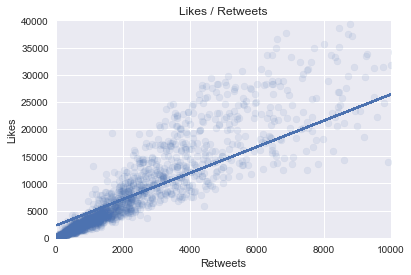

The slope, and thus more likely someone is to like vs retweet is 2.4109063749716344


In [921]:
#We can see a very strong correlation between retweets and favorites
plt.scatter(tw_clean.retweets, tw_clean.favorites, alpha=1/10)
plt.xlabel('Retweets')
plt.ylabel('Likes')
plt.title('Likes / Retweets')
plt.xlim([0, 10000])
plt.ylim([0, 40000])
m, b = np.polyfit(tw_clean.retweets, tw_clean.favorites, 1)
plt.plot(tw_clean.retweets, m*tw_clean.retweets + b, '-')

plt.savefig('likeretweet.png', bbox_inches='tight')

plt.show()
print('The slope, and thus more likely someone is to like vs retweet is {}' .format(m))

In [889]:
tw_favorites = tw_clean.sort_values(by=['favorites'], ascending=False)
tw_favorites

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,favorites
309,822872901745569793,NaN,NaN,2017-01-21 18:26:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,https://twitter.com/dog_rates/status/822872901745569793/photo/1,13,10,None,...,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True,47760,131912
774,744234799360020481,NaN,NaN,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,https://twitter.com/dog_rates/status/744234799360020481/video/1,13,10,None,...,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True,78822,130170
399,807106840509214720,NaN,NaN,2016-12-09 06:17:20,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,https://twitter.com/dog_rates/status/807106840509214720/video/1,13,10,Stephan,...,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True,61845,122901
58,879415818425184262,NaN,NaN,2017-06-26 19:07:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,https://twitter.com/dog_rates/status/879415818425184262/video/1,13,10,Duddles,...,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True,45504,107466
108,866450705531457537,NaN,NaN,2017-05-22 00:28:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr","https://twitter.com/dog_rates/status/866450705531457537/photo/1,https://twitter.com/dog_rates/status/866450705531457537/photo/1",13,10,Jamesy,...,0.905334,True,Boston_bull,0.078060,True,pug,0.001771,True,32581,106205
333,819004803107983360,NaN,NaN,2017-01-11 02:15:36,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,"https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1",14,10,Bo,...,0.351308,True,toy_poodle,0.271929,True,Tibetan_terrier,0.094759,True,41894,94898
135,859196978902773760,NaN,NaN,2017-05-02 00:04:57,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,,...,0.224218,False,malamute,0.216163,True,Persian_cat,0.128383,False,32452,93949
93,870374049280663552,NaN,NaN,2017-06-01 20:18:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She really likes the planet. Would hate to see willful ignorance and the denial of fairly elemental science destroy it. 13/10 https://t.co/T1xlgaPujm,https://twitter.com/dog_rates/status/870374049280663552/photo/1,13,10,Zoey,...,0.841001,True,Great_Pyrenees,0.099278,True,Labrador_retriever,0.032621,True,27394,84475
401,806629075125202948,NaN,NaN,2016-12-07 22:38:52,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Good afternoon class today we're goi

# And here is our complete dataset with all the info

In [ ]:
tw_clean.sample(10)